In [2]:
# install all libraries that are not pre-installed in colab
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=30ba36dbb7af2cbf0abda556d69843fce591e01a1d6bea8a1f3a8757ffe61449
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
# check if all files have been uploaded
import os
content = os.listdir()
assert "views" in content
assert "hyperparameters.json" in content

In [1]:
raise Exception("Deprecated cell. You should not need to use this.")

import json
import os

with open('view_info.json', 'r') as f:
    view_data = json.load(f)
data_path = '/'.join(view_data[0]['image'].split('/')[:-1])
if not os.path.exists(data_path):
    for i in range(len(view_data)):
      view_data[i]['image'] = view_data[i]['image'].split('/')[-1]
    with open('view_info.json', 'w') as f:
      json.dump(view_data, f, indent=2)

In [ ]:
# main training/resume/eval loop. wandb logging.
import json
import argparse
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
import wandb


class FourierLayer(nn.Module):
    def __init__(self, n_fourier_features: int, freq_spacing: str = 'logarithmic', fan_in: int = None, no_grad: bool = True):
        super().__init__()
        self.nff = n_fourier_features
        self.fan_in = fan_in
        if fan_in is not None:
            self.out_dim = 2 * fan_in * self.nff
        else:
            self.out_dim = None
        self.freq_spacing = freq_spacing
        self.no_grad = no_grad

    def forward_fn(self, x):
        x = x.view(x.shape + (1,))
        if self.freq_spacing == 'logarithmic':
            feature_mul = 2 ** torch.arange(0, self.nff, device=x.device)
        elif self.freq_spacing == 'linear':
            feature_mul = torch.arange(1, self.nff + 1, device=x.device)
        else:
            raise Exception(f'Unknown frequency spacing paradigm: {self.freq_spacing}')
        sines = torch.sin(x * feature_mul)
        cosines = torch.cos(x * feature_mul)
        del feature_mul
        # sines.shape = cosines.shape
        out = (torch.concat([
            sines.view(sines.shape + (1,)),
            cosines.view(cosines.shape + (1,))
        ],
            dim=-1)
               .flatten(-3, -1)
               )
        del sines, cosines
        return out

    def forward(self, x):
        assert not (self.no_grad and x.requires_grad), "FourierLayer is set to no_grad = True, but input requires grad."
        if self.no_grad:
            with torch.no_grad():
                return self.forward_fn(x).detach()
        return self.forward_fn(x)


def factorize_with_smallest_difference(n):
    factors = []

    for i in range(1, int(n ** 0.5) + 1):
        if n % i == 0:
            factors.append((i, n // i))

    best_factors = min(factors, key=lambda pair: abs(pair[0] - pair[1]))

    return best_factors


"""parser = argparse.ArgumentParser()
parser.add_argument('--path', type=str, default='views', help="path to .json file containing the image info")
parser.add_argument('--train', action='store_true', help="train a new model")
parser.add_argument('--eval', action='store_true', help="evaluate currently saved model")
parser.add_argument('--resume', action='store_true', help="continue training currently saved model")
parser.add_argument('--cuda', action='store_true', help="use cuda for training")
parser.add_argument('--verbose', action='store_true', help="print epoch to console")
parser.add_argument('--wandb', type=str, default=None, help="wandb project to log this run to")
args = parser.parse_args()"""  # because colab does not support this (or I am too dumb to find it)
args = argparse.Namespace(
    path='views',
    train=False,
    eval=False,
    resume=True,
    cuda=True,
    verbose=True,
    wandb="arxiv_2006.10739"
)

assert args.train or args.eval or args.resume, "You must provide one of --train, --eval or --resume"
assert sum(
    map(int, [args.train, args.eval, args.resume])) == 1, "You must provide only one of --train, --eval or --resume"

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# load hyperparams from file
with open('hyperparameters.json') as f:
    hyperparams_dict = json.load(f)
    hyperparams = argparse.Namespace(**hyperparams_dict)

if args.wandb is not None:
    if args.train or args.resume:
        wandb.init(
            project=args.wandb,
            config=hyperparams_dict
        )
    else:
        wandb.init(
            project=args.wandb
        )

# load images
pics, cam_pos, cam_rot = [], [], []
json_fn = None
for fn in os.listdir(f"{args.path}/"):
    if fn.endswith('.json'):
        assert json_fn is None, "More than one json file in data directory. Remove all but the necessary one."
        json_fn = fn

assert json_fn is not None, "Could not find a json file containing dataset info"

with open(f"{args.path}/{json_fn}") as f:
    data_json = json.load(f)

for x in data_json:
    pic = Image.open(x["image"]).convert('RGB')
    pic = transform(pic).permute((2, 1, 0)).unsqueeze(0)
    pics.append(pic)
    pos = torch.tensor(list(map(float, x["position"].split(', '))))
    cam_pos.append(pos)
    rot = torch.tensor(list(map(float, x["rotation"].split(', '))))
    cam_rot.append(rot)

assert all([i.shape == j.shape for i, j in zip(pics, pics[1:])]), "Not all images have the same shape."
pics = torch.concat(pics)
cam_pos = torch.stack(cam_pos)
cam_rot = torch.stack(cam_rot)

if hyperparams.batch_size == -1:
    hyperparams.batch_size = pics.shape[0]
assert pics.shape[
           0] % hyperparams.batch_size == 0, f"Cannot divide {pics.shape[0]} images evenly into {hyperparams.batch_size} groups"
assert pics.shape[
           1] % hyperparams.n_image_splits == 0, f"Cannot horizontally divide images of horizontal size {pics.shape[1]} evenly into {hyperparams.n_image_splits} equal segments"

# define model input
# pure pixel position input + reshape
'''
model_in = torch.concat(
    [torch.arange(pics.shape[1]).unsqueeze(-1).repeat_interleave(pics.shape[2], dim=1).unsqueeze(-1),
     torch.arange(pics.shape[2]).unsqueeze(0).repeat_interleave(pics.shape[1], dim=0).unsqueeze(-1)],
    dim=-1) / torch.tensor(list(pics.shape[1:-1])) * 2 - 1

Does the same thing (but worse) as:
'''
model_in = torch.stack(
    [
        torch.linspace(-1, 1, pics.shape[1]).unsqueeze(-1).repeat_interleave(pics.shape[2], dim=1),
        torch.linspace(-1, 1, pics.shape[2]).unsqueeze(0).repeat_interleave(pics.shape[1], dim=0)
    ],
    dim=-1
)
model_in = model_in.unsqueeze(0).repeat_interleave(pics.shape[0], dim=0)
# reshape camera position and rotation
cam_pos = (cam_pos.view((cam_pos.shape[0], 1, 1, cam_pos.shape[1]))
           .repeat_interleave(model_in.shape[1], dim=1)
           .repeat_interleave(model_in.shape[2], dim=2))
cam_rot = (cam_rot.view((cam_rot.shape[0], 1, 1, cam_rot.shape[1]))
           .repeat_interleave(model_in.shape[1], dim=1)
           .repeat_interleave(model_in.shape[2], dim=2))
# concat
model_in = torch.concat([cam_pos, cam_rot, model_in], dim=-1)

# split model_in into pieces because it requires 600GiB GPU RAM otherwise D:
X = []
Y = []
x_batch_splits = model_in.split(hyperparams.batch_size)
y_batch_splits = pics.split(hyperparams.batch_size)

for x_batch_split, y_batch_split in zip(x_batch_splits, y_batch_splits):
    X.extend(x_batch_split.split(x_batch_split.shape[1] // hyperparams.n_image_splits, dim=1))
    Y.extend(y_batch_split.split(y_batch_split.shape[1] // hyperparams.n_image_splits, dim=1))
    del x_batch_split, y_batch_split

# define the model
if args.train:
    fourier_layer = FourierLayer(
        hyperparams.n_fourier_features,
        hyperparams.frequency_spacing,
        fan_in=model_in.shape[-1]
    )
    model = nn.Sequential(
        fourier_layer,
        nn.Linear(fourier_layer.out_dim, hyperparams.n_hidden),
        nn.ReLU(),
        nn.Linear(hyperparams.n_hidden, hyperparams.n_hidden),
        nn.ReLU(),
        nn.Linear(hyperparams.n_hidden, 3),
        nn.Tanh()
    )
else:
    model = torch.load('model.ckpt')

# define the optimizer
optim = torch.optim.AdamW(model.parameters(), lr=0)
pred = None

# move to gpu
if args.cuda:
    if torch.cuda.is_available():
        # model_in = model_in.to('cuda')  not used anymore!!!
        for i, x in enumerate(X):
            X[i] = x.to('cuda')
        for i, y in enumerate(Y):
            Y[i] = y.to('cuda')
        model = model.to('cuda')
        # pics = pics.to('cuda')  not used anymore!!!
        print('Moved parameters/IO to cuda')
    else:
        raise Exception('Cuda not available -> Failed to move parameters/IO to cuda')

# delete unnecessary variables for gpu memory
del transform, pics, cam_pos, cam_rot, model_in, x_batch_splits, y_batch_splits#, parser

losses = []
n_epochs = 0
last_checkpoint_epoch_group_idx = 0

# main training loop
if args.train or args.resume:
    print("Starting/resuming training...")
    for epoch_group_idx, lr_with_epochs in enumerate(hyperparams.learning_rates):
        losses.append([])
        for i in range(len(optim.param_groups)):
            optim.param_groups[i]['lr'] = lr_with_epochs['lr']
        for e in range(lr_with_epochs['epochs']):
            losses[-1].append([])
            for i, x, y in zip(range(len(X)), X, Y):
                pred = (model(x) + 1) / 2
                L = F.mse_loss(pred, y)
                optim.zero_grad()
                L.backward()
                optim.step()
                losses[-1][-1].append(L.item())
            if args.wandb is not None:
                wandb.log({f"{'train' if args.train else 'resume'}/loss": sum(losses[-1][-1]) / len(losses[-1][-1]), f"{'train' if args.train else 'resume'}/lr": lr_with_epochs['lr']})
            if args.verbose:
                print(f'Epoch {n_epochs}   Loss {sum(losses[-1][-1]) / len(losses[-1][-1])}')
            n_epochs += 1
        if lr_with_epochs['checkpoint'] and sum(losses[-1][-1]) <= sum(losses[last_checkpoint_epoch_group_idx][-1]):  # want to checkpoint and loss is better than at the end of last checkpointed epoch group (an epoch group is a group of epochs with shared lr)
            last_checkpoint_epoch_group_idx = epoch_group_idx
            torch.save(model, 'model.ckpt')
            print("Saved the model to model.ckpt")
else:
    print("Starting evaluation...")
    pred = []
    for i, x in enumerate(X):
        if args.verbose:
            print(f"Eval sample {i}/{len(X)}")
        pred.append(((model(x) + 1) / 2).to('cpu').detach())
    pred = torch.concat(pred)
    print("Generating output plots...")
    # detach and split images (or parts of images if --n-image-splits is bigger than 1)
    imgs = pred.transpose(2, 1).numpy()
    imgs = [imgs[i] for i in range(imgs.shape[0])]
    if args.wandb is not None:
        wandb_pred = [wandb.Image(img.to('cpu').detach().numpy()) for img in imgs]
        wandb_ground_truth = [wandb.Image(x.to('cpu').detach().numpy()) for x in X]
        wandb_eval_table = wandb.Table(columns=["prediction", "ground_truth"], data=zip(wandb_pred, wandb_ground_truth))
        wandb.log({"eval/results": wandb_eval_table})

    num_images = len(imgs)
    num_rows, num_cols = factorize_with_smallest_difference(num_images)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5))

    # Plot each image in its respective subplot
    for i in range(num_images):
        if num_images > 1:
            ax = axes[i]
        else:
            ax = axes  # Handle the case when there's only one image

        ax.imshow(imgs[i])
        ax.set_title(f'Image(/part) {i + 1}')

    # Adjust layout to prevent overlapping titles and labels
    plt.tight_layout()
    print("Showing plots...")
    plt.show()

# in case this code is copied into a notebook
if args.wandb is not None:
    wandb.finish()


In [9]:
wandb.finish()  # in case a cell crashes, this has to be run
wandb.init(
    project="arxiv_2006.10739"
)

In [18]:
[p for p in model.parameters()]

[Parameter containing:
 tensor([[-3.1232e-02,  2.0275e-02,  3.8709e-02,  ..., -2.6420e-03,
          -1.0928e-03,  2.4996e-03],
         [-3.9789e-02,  3.5250e-02, -1.5822e-02,  ...,  4.9967e-03,
           3.0828e-03, -8.6522e-03],
         [ 4.2548e-03,  3.2771e-02, -4.8080e-03,  ...,  2.5962e-03,
           3.1051e-03, -5.5589e-03],
         ...,
         [-4.4885e-02, -3.8984e-02,  2.4464e-02,  ...,  8.9124e-03,
           8.9312e-04,  1.9164e-03],
         [-1.6779e-02,  3.5946e-02,  7.3660e-02,  ..., -6.3942e-03,
          -1.6342e-02, -1.2195e-03],
         [-4.4317e-02, -8.3066e-02,  4.1882e-02,  ...,  8.6526e-04,
          -5.1351e-04, -4.6171e-05]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0146, -0.0891, -0.0392, -0.1279, -0.1036, -0.0574, -0.0838, -0.0898,
         -0.0452, -0.0392, -0.0239, -0.0377, -0.0772, -0.0528, -0.1382, -0.0667,
         -0.1094, -0.0753, -0.0994, -0.0869, -0.0388, -0.1323, -0.1174, -0.0301,
         -0.0816, -0.0443, -

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


AttributeError: ignored

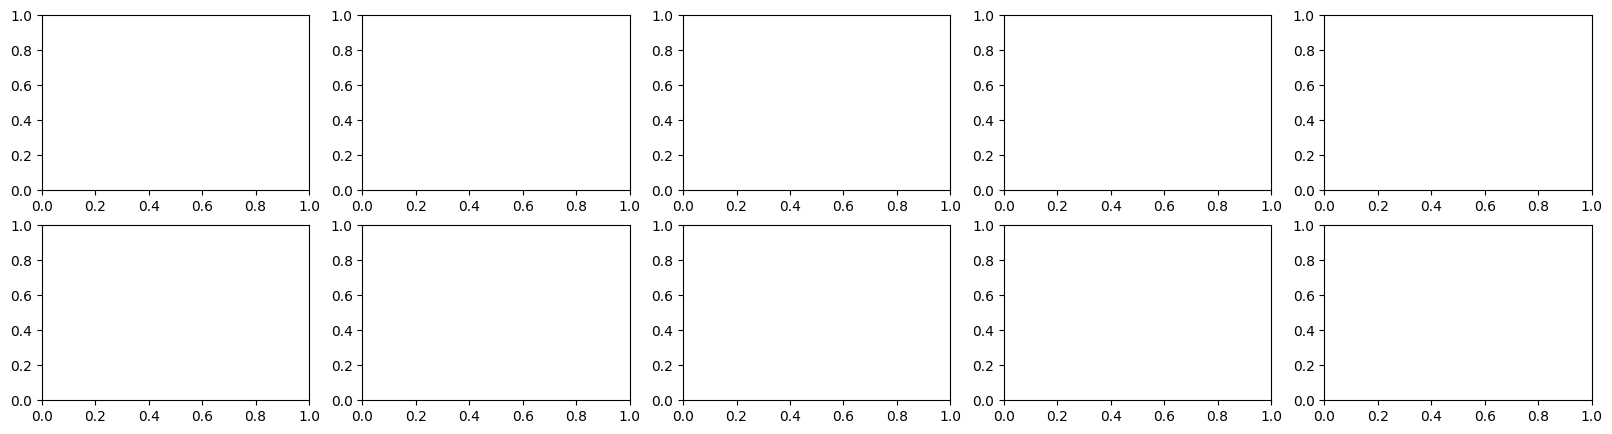

In [10]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import argparse
import json
import os
from PIL import Image
import wandb


class FourierLayer(nn.Module):
    def __init__(self, n_fourier_features: int, freq_spacing: str = 'logarithmic', fan_in: int = None, no_grad: bool = True):
        super().__init__()
        self.nff = n_fourier_features
        self.fan_in = fan_in
        if fan_in is not None:
            self.out_dim = 2 * fan_in * self.nff
        else:
            self.out_dim = None
        self.freq_spacing = freq_spacing
        self.no_grad = no_grad

    def forward_fn(self, x):
        x = x.view(x.shape + (1,))
        if self.freq_spacing == 'logarithmic':
            feature_mul = 2 ** torch.arange(0, self.nff, device=x.device)
        elif self.freq_spacing == 'linear':
            feature_mul = torch.arange(1, self.nff + 1, device=x.device)
        else:
            raise Exception(f'Unknown frequency spacing paradigm: {self.freq_spacing}')
        sines = torch.sin(x * feature_mul)
        cosines = torch.cos(x * feature_mul)
        del feature_mul
        # sines.shape = cosines.shape
        out = (torch.concat([
            sines.view(sines.shape + (1,)),
            cosines.view(cosines.shape + (1,))
        ],
            dim=-1)
               .flatten(-3, -1)
               )
        del sines, cosines
        return out

    def forward(self, x):
        assert not (self.no_grad and x.requires_grad), "FourierLayer is set to no_grad = True, but input requires grad."
        if self.no_grad:
            with torch.no_grad():
                return self.forward_fn(x).detach()
        return self.forward_fn(x)


# todo: add wandb here and test wandb in main


def factorize_with_smallest_difference(n):
    factors = []

    for i in range(1, int(n ** 0.5) + 1):
        if n % i == 0:
            factors.append((i, n // i))

    best_factors = min(factors, key=lambda pair: abs(pair[0] - pair[1]))

    return best_factors


"""parser = argparse.ArgumentParser()
parser.add_argument('--cuda', action='store_true')
parser.add_argument('--n-frames', type=int)
parser.add_argument('--wandb', type=str, default=None, help="name of wandb project to log this to")
args = parser.parse_args()"""  # replace with hardcoded namespace because for colab
args = argparse.Namespace(
    path="views",
    cuda=True,
    n_frames=10,
    wandb="arxiv_2006.10739"
)

assert not args.cuda or torch.cuda.is_available(), "Cuda is not available. Make sure you have pytorch installed with cuda or run this file without --cuda to use cpu instead."

model = torch.load('model.ckpt')


# get the image size (=resolution)
json_fn = None
for fn in os.listdir(f"{args.path}/"):
    if fn.endswith('.json'):
        assert json_fn is None, "More than one json file in data directory. Remove all but the necessary one."
        json_fn = fn

assert json_fn is not None, "Could not find a json file containing dataset info"

with open(f"{args.path}/{json_fn}") as f:
    data_json = json.load(f)

img_path = data_json[0]['image']
resolution = (1536, 864)#Image.open(img_path).size

grid_in = torch.stack(
    [
        torch.linspace(-1, 1, resolution[0]).unsqueeze(-1).repeat_interleave(resolution[1], dim=1),
        torch.linspace(-1, 1, resolution[1]).unsqueeze(0).repeat_interleave(resolution[0], dim=0)
    ],
    dim=-1
)
if args.cuda:
    model = model.to('cuda')
    grid_in = grid_in.to('cuda')


# Empty function for feeding data through the model
def predict_view(position, rotation):
    model_in = (torch.tensor(position + rotation, dtype=torch.float32)
                .view((1, 1, -1))
                .repeat_interleave(resolution[0], dim=0)
                .repeat_interleave(resolution[1], dim=1))
    if args.cuda:
        model_in = model_in.to('cuda')
    model_in = torch.concat([model_in, grid_in], dim=-1)
    model_in = model_in.unsqueeze(0)
    model_in = model_in.detach()
    model_in.requires_grad = False
    model_out = (model(model_in) + 1) / 2
    del model_in
    out = model_out.squeeze(0).to('cpu').detach().transpose(1, 0).numpy()
    del model_out
    return out


if args.wandb is not None:
    wandb.login(anonymous='allow')
    wandb.init(
        project=args.wandb
    )

# Parameters for the animation
num_frames = args.n_frames
radius = 5.0
angle_steps = np.linspace(0, 2 * np.pi, num_frames)

# Initialize figure and 3D axes
num_rows, num_cols = factorize_with_smallest_difference(num_frames)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))

# List to store frames
animation_frames = []

# Generate camera positions and rotations
camera_positions = [
    [radius * np.cos(angle), radius * np.sin(angle), 3.0]
    for angle in angle_steps
]
camera_rotations = [
    [0, 0, np.arctan2(-position[1], -position[0])]
    for position in camera_positions
]

wandb_image_table = wandb.Table(columns=["frames"])  # only used if wandb project name was provided using --wandb

# Generate images using the model for each camera position and rotation
for frame in range(num_frames):
    camera_position = camera_positions[frame]
    camera_rotation = camera_rotations[frame]

    # Feed camera data through the model and get the generated image
    generated_image = predict_view(camera_position, camera_rotation)
    if args.wandb is not None:
        wandb_img = wandb.Image(generated_image)
        wandb_image_table.add_row(wandb_img)

    # Display the generated image in the respective subplot
    if num_frames > 1:
        ax = axes[frame // num_cols, frame % num_cols]
    else:
        ax = axes  # Handle the case when there's only one frame

    ax.imshow(generated_image)
    ax.set_title(f'Frame {frame + 1}')
    ax.axis('off')

if args.wandb is not None:
    wandb.log({'animation/images': wandb_image_table})
    wandb.finish()

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

# Show the plot
plt.show()
